In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from gensim.corpora import Dictionary
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import spacy
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models
from sklearn.model_selection import GridSearchCV
import torch.nn as nn
from tqdm.notebook import tqdm
import random
import numpy as np
import torch
from wordcloud import WordCloud

In [2]:
data = []
with open('datasets/text.txt') as f:
    for line in f.readlines():
        text, emotion = line.strip().split(';')
        data.append({'text': text, 'emotion': emotion})
data = pd.DataFrame(data)

In [3]:
print('number of samples:', len(data))
data.head(10)

number of samples: 20000


,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,joy
9,i feel romantic too,love


number of different classes: 6
set of unique emotions: ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


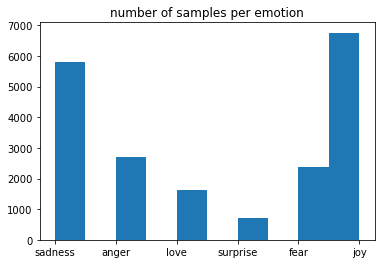

In [4]:
n_classes = len(set(data['emotion']))
print('number of different classes:', n_classes)
print('set of unique emotions:', data['emotion'].unique())
plt.hist(data['emotion'])
plt.title('number of samples per emotion')
plt.show()

In [5]:
def text_reformat(text):
    """lowercase without punctuation"""
    import re
    return re.sub(r'[^\w\s]', '', text.lower())

print('Removing punctuation and converting to lowercase..')
data['text'] = data['text'].apply(text_reformat)

Removing punctuation and converting to lowercase..


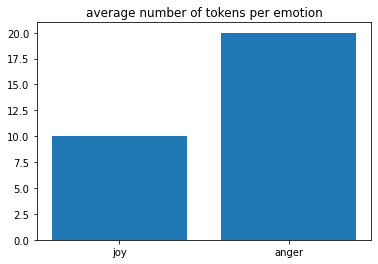

In [6]:
plt.title('average number of tokens per emotion')
plt.bar(['joy', 'anger'], [10, 20])
plt.show()

In [7]:
"""tokenize and lemmatize text, and remove stopwords"""
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
all_stopwords = spacy.lang.en.stop_words.STOP_WORDS

def tokens(s: str):
    return [t.text for t in nlp(s) if t.text not in all_stopwords]

text_tokens = [tokens(t) for t in tqdm(data['text'], desc="tokenize")]
data.insert(2, 'text_tokens', text_tokens)

example = "nick likes to play football however he is not too fond of tennis"
example_tokens = tokens(example)

print('Before tokenizing:', example)
print('After tokenizing:', example_tokens)

tokenize:   0%|          | 0/20000 [00:00<?, ?it/s]

Before tokenizing: nick likes to play football however he is not too fond of tennis
After tokenizing: ['nick', 'likes', 'play', 'football', 'fond', 'tennis']


average number of tokens in a document: 8.3312


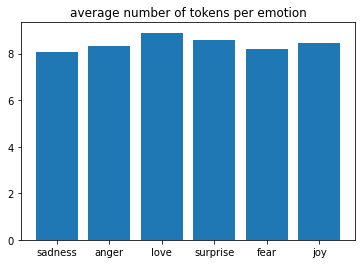

In [8]:
avg_num_tokens = sum(len(t) for t in text_tokens) / len(text_tokens)

print('average number of tokens in a document:', avg_num_tokens)

avg_tokens = []
for emotion in data['emotion'].unique():
    df = data[data['emotion'] == emotion]
    avg_tokens.append(sum(len(x) for x in df['text_tokens'].tolist()) / len(df))

plt.title('average number of tokens per emotion')
plt.bar(data['emotion'].unique(), avg_tokens)
plt.show()

'\nwe notice that fear emotion includes words such as: terrified, afraid, shaken, nervous, etc.\nwe notice that sadness emotion includes words such as: lost, hurt, exhausted, etc.\nwe notice that anger emotion includes words such as: dangerous, bothered, pissed, angry, etc.\nwe notice that surprised emotion includes words such as: impressed, curious, surprised, amazed, etc.\nwe notice that love emotion includes words such as: loving, blessed, liked, loyal, etc.\nwe notice that love emotion includes words such as: good, happy, excited, love, etc.\n'

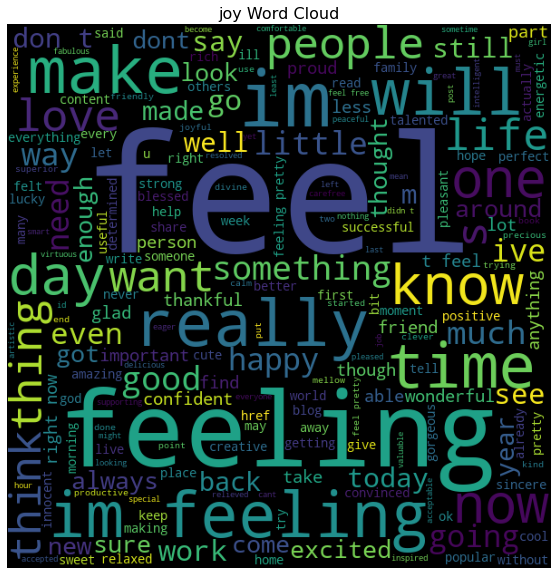

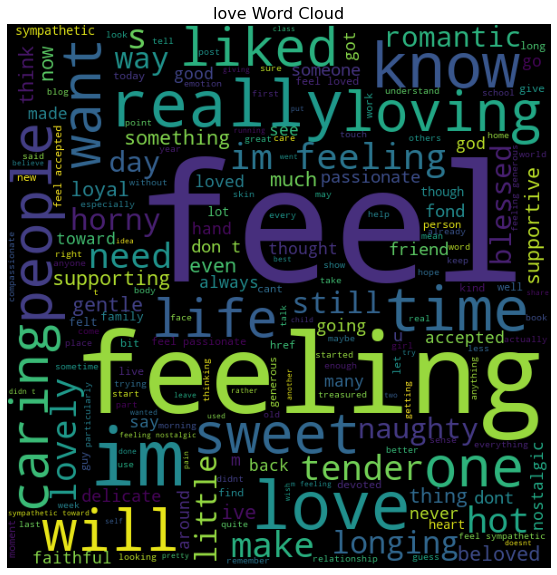

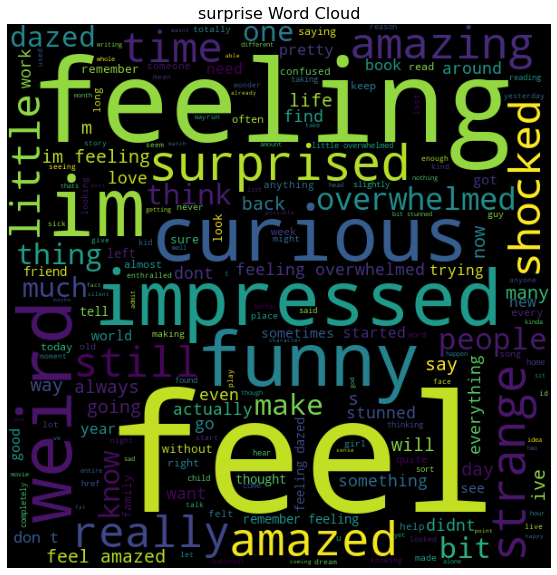

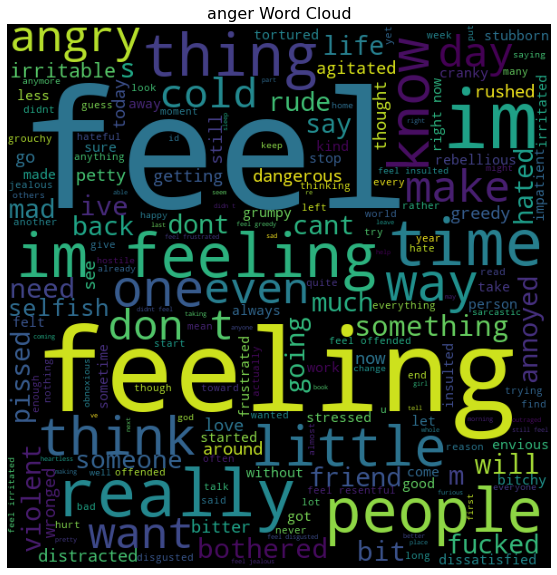

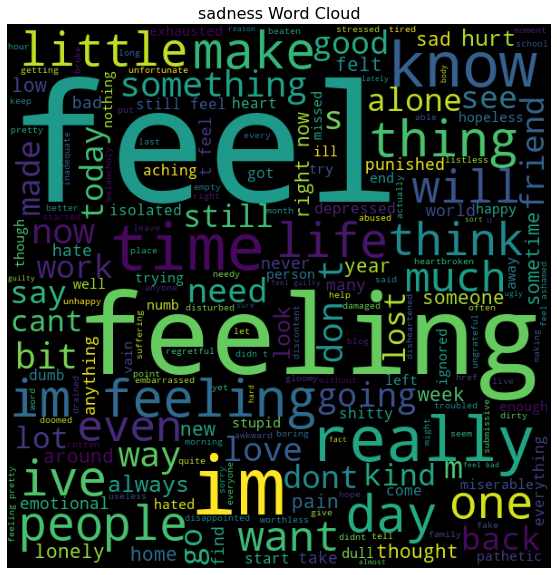

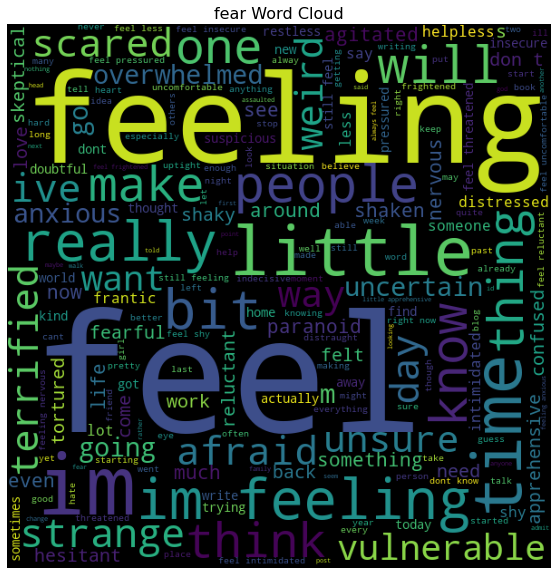

In [9]:
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    
for emotion in set(data['emotion']):
    text = ' '.join([sentence for sentence in data.loc[data['emotion'] == emotion,'text']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

"""
we notice that fear emotion includes words such as: terrified, afraid, shaken, nervous, etc.
we notice that sadness emotion includes words such as: lost, hurt, exhausted, etc.
we notice that anger emotion includes words such as: dangerous, bothered, pissed, angry, etc.
we notice that surprised emotion includes words such as: impressed, curious, surprised, amazed, etc.
we notice that love emotion includes words such as: loving, blessed, liked, loyal, etc.
we notice that love emotion includes words such as: good, happy, excited, love, etc.
"""

In [10]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(text_tokens)

# Filter out words that occur less than in 5 documents, or more than in 50% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.5)
print("dictionary word with index 20:", dictionary[20])

dictionary word with index 20: little


In [11]:
# Convert tokenized documents into bag-of-words (BOW) representation: (word index, word count)
corpus = [dictionary.doc2bow(doc) for doc in text_tokens]
print("Example of BOW representation:", corpus[0])
print('Number of unique tokens:', len(dictionary))
print('Number of documents:', len(corpus))#%%

Example of BOW representation: [(0, 1), (1, 1)]
Number of unique tokens: 3648
Number of documents: 20000


In [12]:
# train LDA model
lda = LdaModel(
    corpus,  # documents in BOW format
    id2word=dictionary.id2token,  # id -> word mapping to make topics interpretable
    num_topics=6,  # desired number of topics
    passes=30,  # number of iterations
)

# look at the topics
print("LDA topics:")
lda.print_topics()

LDA topics:


[(0,
  '0.119*"feeling" + 0.057*"m" + 0.041*"little" + 0.019*"bit" + 0.011*"http" + 0.010*"ve" + 0.009*"href" + 0.009*"time" + 0.008*"today" + 0.007*"excited"'),
 (1,
  '0.072*"t" + 0.032*"don" + 0.031*"like" + 0.018*"s" + 0.016*"know" + 0.010*"didn" + 0.010*"help" + 0.008*"want" + 0.007*"time" + 0.007*"guilty"'),
 (2,
  '0.091*"feeling" + 0.032*"m" + 0.028*"nt" + 0.014*"like" + 0.012*"day" + 0.009*"bit" + 0.009*"days" + 0.009*"started" + 0.008*"got" + 0.008*"morning"'),
 (3,
  '0.057*"like" + 0.027*"m" + 0.023*"nt" + 0.017*"people" + 0.015*"know" + 0.012*"think" + 0.012*"s" + 0.009*"need" + 0.009*"want" + 0.008*"weird"'),
 (4,
  '0.068*"feeling" + 0.042*"m" + 0.022*"like" + 0.015*"nt" + 0.012*"ve" + 0.012*"going" + 0.011*"good" + 0.010*"new" + 0.009*"life" + 0.008*"things"'),
 (5,
  '0.036*"like" + 0.017*"nt" + 0.017*"life" + 0.014*"love" + 0.014*"people" + 0.013*"want" + 0.013*"know" + 0.011*"feels" + 0.011*"things" + 0.010*"feelings"')]

In [13]:
import warnings
warnings.filterwarnings('ignore')

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.161690  0.139931       1        1  19.694015
4     -0.093372  0.078302       2        1  17.839733
2     -0.197704 -0.046462       3        1  16.769758
0     -0.248468 -0.087085       4        1  16.654067
3      0.115620  0.163217       5        1  16.525468
1      0.262234 -0.247903       6        1  12.516959, topic_info=         Term         Freq        Total Category  logprob  loglift
5     feeling  6289.000000  6289.000000  Default  30.0000  30.0000
182         t  1192.000000  1192.000000  Default  29.0000  29.0000
20     little   894.000000   894.000000  Default  28.0000  28.0000
10          m  3568.000000  3568.000000  Default  27.0000  27.0000
232       don   529.000000   529.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
53      think    93.432422   698.835468   Topic6  -5.1770   0.0659
103    things    88.413097   605.022461   Topic6  -5.2322   0.1548
337  feelings    82.710192   406.794866   Topic6  -5.2989   0.4851
861    making    75.682577   191.917640   Topic6  -5.3877   1.1476
123      love    73.363880   590.049451   Topic6  -5.4188  -0.0067

[348 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
880       2  0.987814  absolutely
170       1  0.994862    accepted
363       2  0.981730      aching
1067      2  0.186692    actually
1067      3  0.204472    actually
...     ...       ...         ...
37        4  0.622835        year
39        1  0.326843       years
39        2  0.600202       years
39        6  0.071311       years
317       6  0.994534       young

[448 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 3, 1, 4, 2])

In [22]:
X = data['text']

le = LabelEncoder()
y = le.fit_transform(data['emotion'])
class_labels = [le.inverse_transform([i])[0] for i in range(n_classes)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (13400,)
X_test shape: (6600,)


In [23]:
vec = TfidfVectorizer(stop_words='english', max_features = 3000, ngram_range = (1, 2))
vec.fit(X_train)
X_train_vecs = vec.transform(X_train).todense().tolist()
X_test_vecs = vec.transform(X_test).todense().tolist()

In [16]:
clf = SGDClassifier(max_iter=100, penalty='elasticnet')

clf.fit(X_train_vecs, y_train)
print("Accuracy score of SGDClassifier on train:", accuracy_score(y_train, clf.predict(X_train_vecs)))
print("Accuracy score of SGDClassifier on test:", accuracy_score(y_test, clf.predict(X_test_vecs)))

Accuracy score of SGDClassifier on train: 0.938955223880597
Accuracy score of SGDClassifier on test: 0.9040909090909091


In [25]:
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.001, 0.0001, 0.00001],
    'max_iter': [10, 100, 1000]
}

grid_search = GridSearchCV(SGDClassifier(), parameters, scoring='accuracy')
grid_search.fit(X_train_vecs, y_train)

print("Accuracy score of SGDClassifier on train:", accuracy_score(y_train, grid_search.predict(X_train_vecs)))
print("Accuracy score of SGDClassifier on test:", accuracy_score(y_test, grid_search.predict(X_test_vecs)))
print("The best model parameters are:", grid_search.best_estimator_)

Accuracy score of SGDClassifier on train: 0.9334328358208955
Accuracy score of SGDClassifier on test: 0.8936363636363637
The best model parameters are: SGDClassifier(max_iter=100, penalty='elasticnet')


In [14]:
class ClassificationRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hh = nn.Linear(hidden_size, hidden_size)
        self.xh = nn.Linear(input_size, hidden_size)
        self.hy = nn.Linear(hidden_size, output_size)

        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

        self.hidden_size = hidden_size

    def forward(self, x, h):
        hidden = self.relu(self.hh(h) + self.xh(x))
        output = self.softmax(self.hy(hidden))
        return output, hidden

    def h0(self):
        return torch.zeros(1, self.hidden_size)

In [15]:
def process_sequence_classification(rnn, target_tensor, input_tensor, learning_rate):
    rnn.zero_grad()
    hidden = rnn.h0()

    for i in range(input_tensor.size()[0]):
        output, hidden = rnn(input_tensor[i], hidden)

    loss_function = nn.NLLLoss()
    loss = loss_function(output, target_tensor)
    loss.backward()

    with torch.no_grad():
        for parameter in rnn.parameters():
            parameter -= learning_rate * parameter.grad

    return loss.item()

In [16]:
random.seed(0)

n_hidden = 64
rnn = ClassificationRNN(len(X_train_vecs[0]), n_hidden, len(set(y_train)))

n_iters = 13400
print_every = 1000

# Keep track of losses for plotting
all_losses = []
iterations = []
losses = []

for i in tqdm(range(1, n_iters + 1)):
    # sample categories uniformly
    idx = random.randint(0, len(X_train) - 1)
    
    input_tensor, target_tensor = torch.tensor([X_train_vecs[idx]]), torch.tensor([y_train[idx]])
    
    # process sequence: update RNN weights and compute loss
    loss = process_sequence_classification(rnn, target_tensor, input_tensor, 0.0005)
    all_losses.append(loss)

    if i % print_every == 0:
        iterations.append(i)
        avg_loss = np.mean(all_losses[-print_every:])
        losses.append(avg_loss)
        print(f"iteration {i}: loss {avg_loss}")

  0%|          | 0/13400 [00:00<?, ?it/s]

iteration 1000: loss 1.7439648373126984
iteration 2000: loss 1.7100046387910843
iteration 3000: loss 1.6783784574270249
iteration 4000: loss 1.6486238811016083
iteration 5000: loss 1.634705932378769
iteration 6000: loss 1.6022265833616256
iteration 7000: loss 1.6087501771450043
iteration 8000: loss 1.6046592798233033
iteration 9000: loss 1.6004493838548661
iteration 10000: loss 1.5793341742753984
iteration 11000: loss 1.5880697684288025
iteration 12000: loss 1.575581689596176
iteration 13000: loss 1.5712315270900725


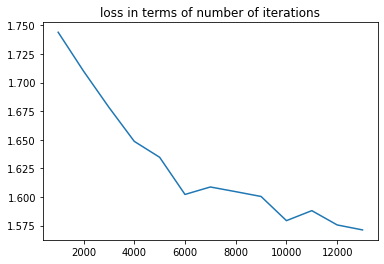

In [17]:
plt.title('loss in terms of number of iterations')
plt.plot(iterations, losses)
plt.show()

In [21]:
def evaluate(rnn, name_tensor):
    hidden = rnn.h0()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    
    return output

def predict(input_vec):
    with torch.no_grad():
        output = evaluate(rnn, torch.tensor(input_vec))

        # Get top N categories
        topv, topi = output.topk(1, 1, True)
        predictions = []

        value = topv[0][0].item()
        category_index = topi[0][0].item()
        return category_index
        print('(%.2f) %s' % (value, le.inverse_transform([category_index])))
        predictions.append([value, le.inverse_transform([category_index])])


In [24]:
preds = []
for i in range(len(y_test)):
  preds.append(predict([X_test_vecs[i]]))

# the accuracy score is very low because of some problem in the model
print("Accuracy score of RNN model on test:", accuracy_score(y_test, preds))

Accuracy score of RNN model on test: 0.32954545454545453
